# On the day Appointments 

1. Refresh catalog for GP appointments if needed 
2. Ensure this does not break existing notebooks/analysis and make changes if required.
3. Calculate % on the day (same days) appointments for each month in each ICB Area 
4. Line plot of last 1+ years % on the day appointments by ICB.
5. Bar plot for the last 12 months of appointment data. (x values: ICB, y values:% on the day appointments)
6. Output Yaml as :    
   
   {07K : 0.3, .... }
   

## Importing libraries

In [1]:
from os import chdir
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    chdir('..')

# Library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import warnings

# SNEE style import
from sneeifstyles import mpl_style

# project imports from src
from src.schemas import DataCatalog
import src.constants as constants


# Suppressing warnings
import warnings
warnings.filterwarnings('ignore')


# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

## Loading the catalog with GP Appointments dataframe (07-2021 to 12-2023)

In [2]:
# Load data catalog
data_catalog = DataCatalog.load_from_yaml("data_catalog.yaml")

gp_appts_catalog_entry = data_catalog.single_data_sources[0]
gp_appts_df = gp_appts_catalog_entry.load()
print(gp_appts_catalog_entry.zip_file.namelist())

['Regional_CSV_WYorks.csv', 'Regional_CSV_Sussex.csv', 'Regional_CSV_SurreyHearts.csv', 'Regional_CSV_SuffolkNEEssex.csv', 'Regional_CSV_StaffsStoke.csv', 'Regional_CSV_Somerset.csv', 'Regional_CSV_ShropsTelfordWrekin.csv', 'Regional_CSV_SYorks.csv', 'Regional_CSV_SWLondon.csv', 'Regional_CSV_SELondon.csv', 'Regional_CSV_NottinghamNotts.csv', 'Regional_CSV_Northamptonshire.csv', 'Regional_CSV_NorfolkWaveney.csv', 'Regional_CSV_NWLondon.csv', 'Regional_CSV_NENCumbria.csv', 'Regional_CSV_NELondon.csv', 'Regional_CSV_NCLondon.csv', 'Regional_CSV_MidSEssex.csv', 'Regional_CSV_Lincolnshire.csv', 'Regional_CSV_LeicesterLshire.csv', 'Regional_CSV_LancsSCumbria.csv', 'Regional_CSV_KentMedway.csv', 'Regional_CSV_HumberNYorks.csv', 'Regional_CSV_HertfordshireWEssex.csv', 'Regional_CSV_HereWorcs.csv', 'Regional_CSV_HampshireIoW.csv', 'Regional_CSV_Gloucestershire.csv', 'Regional_CSV_GManchesterHSCP.csv', 'Regional_CSV_FrimleyHealth.csv', 'Regional_CSV_Dorset.csv', 'Regional_CSV_Devon.csv', 'Regio

## Pre-processing

In [3]:
# Getting the data for SNEE ICB only
dfs = []
for ccg_name in gp_appts_catalog_entry.zip_file.namelist():
    if ccg_name == "Regional_CSV_SuffolkNEEssex.csv":
        gp_appts_catalog_entry.csv_file = ccg_name
        dfs.append(gp_appts_catalog_entry.load())

snee_appointments_df = pd.concat(dfs, axis=0)


# Adding a boolean column for same day appointments
snee_appointments_df['sameday'] = snee_appointments_df['TIME_BETWEEN_BOOK_AND_APPT'] == 'Same Day'

# Replacing the sub-icb location codes with names
snee_appointments_df['SUB_ICB_LOCATION_CODE'] = snee_appointments_df['SUB_ICB_LOCATION_CODE'].replace({"06L": 'Ipswich & East Suffolk', "07K": 'West Suffolk', "06T": 'North East Essex'})

# Display the dataframe
snee_appointments_df.head()

,SUB_ICB_LOCATION_CODE,SUB_ICB_LOCATION_ONS_CODE,SUB_ICB_LOCATION_NAME,ICB_ONS_CODE,ICB_NAME,REGION_ONS_CODE,REGION_NAME,APPOINTMENT_MONTH,APPT_STATUS,HCP_TYPE,APPT_MODE,TIME_BETWEEN_BOOK_AND_APPT,COUNT_OF_APPOINTMENTS,sameday
0,Ipswich & East Suffolk,E38000086,NHS Suffolk and North East Essex ICB - 06L,E54000023,NHS Suffolk and North East Essex Integrated Ca...,E40000007,East of England,NOV2021,Attended,GP,Face-to-Face,1 Day,3207,False
1,Ipswich & East Suffolk,E38000086,NHS Suffolk and North East Essex ICB - 06L,E54000023,NHS Suffolk and North East Essex Integrated Ca...,E40000007,East of England,NOV2021,Attended,GP,Face-to-Face,15 to 21 Days,1270,False
2,Ipswich & East Suffolk,E38000086,NHS Suffolk and North East Essex ICB - 06L,E54000023,NHS Suffolk and North East Essex Integrated Ca...,E40000007,East of England,NOV2021,Attended,GP,Face-to-Face,2 to 7 Days,5636,False
3,Ipswich & East Suffolk,E38000086,NHS Suffolk and North East Essex ICB - 06L,E54000023,NHS Suffolk and North East Essex Integrated Ca...,E40000007,East of England,NOV2021,Attended,GP,Face-to-Face,22 to 28 Days,886,False
4,Ipswich & East Suffolk,E38000086,NHS Suffolk and North East Essex ICB - 06L,E54000023,NHS Suffolk and North East Essex Integrated Ca...,E40000007,East of England,NOV2021,Attended,GP,Face-to-Face,8 to 14 Days,2736,False


## 3. Calculate % on the day (same days) appointments for each month in each ICB Area 

In [4]:
# Calculating the sum of all appointments
all_appointments_df = snee_appointments_df[['SUB_ICB_LOCATION_CODE', "APPOINTMENT_MONTH", "TIME_BETWEEN_BOOK_AND_APPT","COUNT_OF_APPOINTMENTS"]].groupby(['SUB_ICB_LOCATION_CODE', 'APPOINTMENT_MONTH']).sum().reset_index()


# Calculating the sum of same day appointments
same_day_appointments_df = snee_appointments_df[['SUB_ICB_LOCATION_CODE', "APPOINTMENT_MONTH", "TIME_BETWEEN_BOOK_AND_APPT","COUNT_OF_APPOINTMENTS"]]
same_day_appointments_df = same_day_appointments_df.loc[snee_appointments_df["TIME_BETWEEN_BOOK_AND_APPT"] == "Same Day"].groupby(['SUB_ICB_LOCATION_CODE',"APPOINTMENT_MONTH"]).sum().reset_index()


# Dataframe with percentage of same day appointments
pct_appointments_df = pd.DataFrame()

pct_appointments_df['SUB_ICB_CODE'] = all_appointments_df['SUB_ICB_LOCATION_CODE']
pct_appointments_df['MONTH_YEAR'] = pd.to_datetime(all_appointments_df['APPOINTMENT_MONTH']).dt.to_period('M')
pct_appointments_df['YEAR'] = pct_appointments_df['MONTH_YEAR'].dt.year
pct_appointments_df['ALL_APPOINTMENTS'] = all_appointments_df['COUNT_OF_APPOINTMENTS']
pct_appointments_df['SAME_DAY_APPOINTMENTS'] = same_day_appointments_df['COUNT_OF_APPOINTMENTS']
pct_appointments_df["PCT_SAME_DAY_APPT"] = (pct_appointments_df['SAME_DAY_APPOINTMENTS']/pct_appointments_df['ALL_APPOINTMENTS']*100).round(2)

pct_appointments_df.head()

,SUB_ICB_CODE,MONTH_YEAR,YEAR,ALL_APPOINTMENTS,SAME_DAY_APPOINTMENTS,PCT_SAME_DAY_APPT
0,Ipswich & East Suffolk,2022-04,2022,165467,79802,48.23
1,Ipswich & East Suffolk,2023-04,2023,168059,75320,44.82
2,Ipswich & East Suffolk,2024-04,2024,245501,123062,50.13
3,Ipswich & East Suffolk,2022-08,2022,178667,84120,47.08
4,Ipswich & East Suffolk,2023-08,2023,194925,86856,44.56


## 4. Line plot of last 1+ years % on the day appointments by ICB.

In [5]:
# Separate dataframes for each year (2023-22-21) for line plots
pct_appointments_df_2023 = pct_appointments_df[pct_appointments_df['YEAR'] == 2023]
pct_appointments_df_2022 = pct_appointments_df[pct_appointments_df['YEAR'] == 2022]
pct_appointments_df_2021 = pct_appointments_df[pct_appointments_df['YEAR'] == 2021]

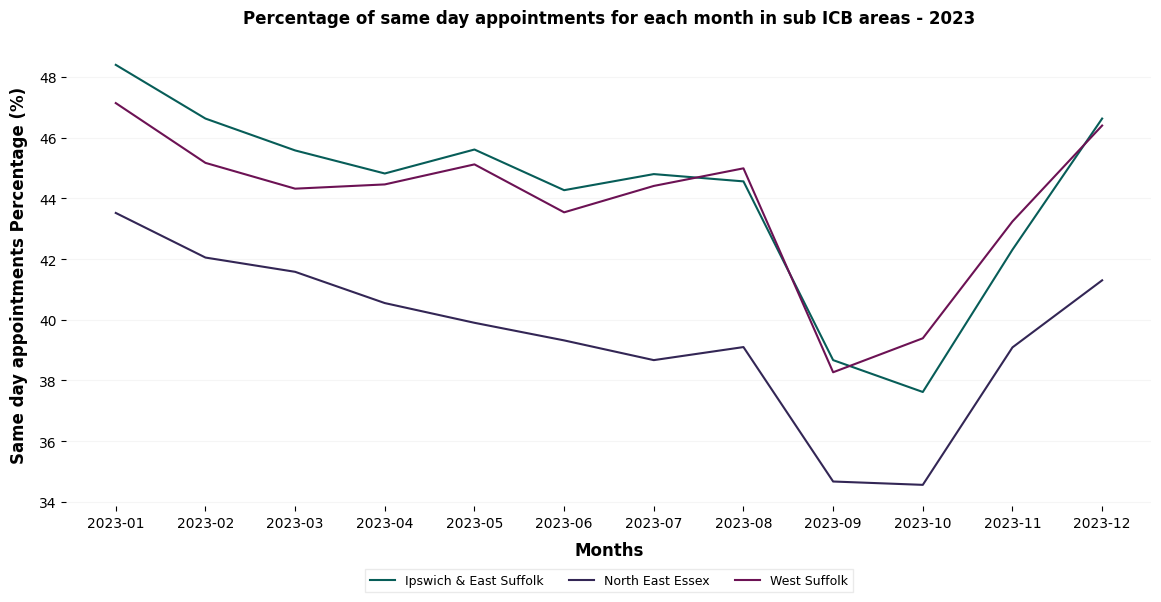

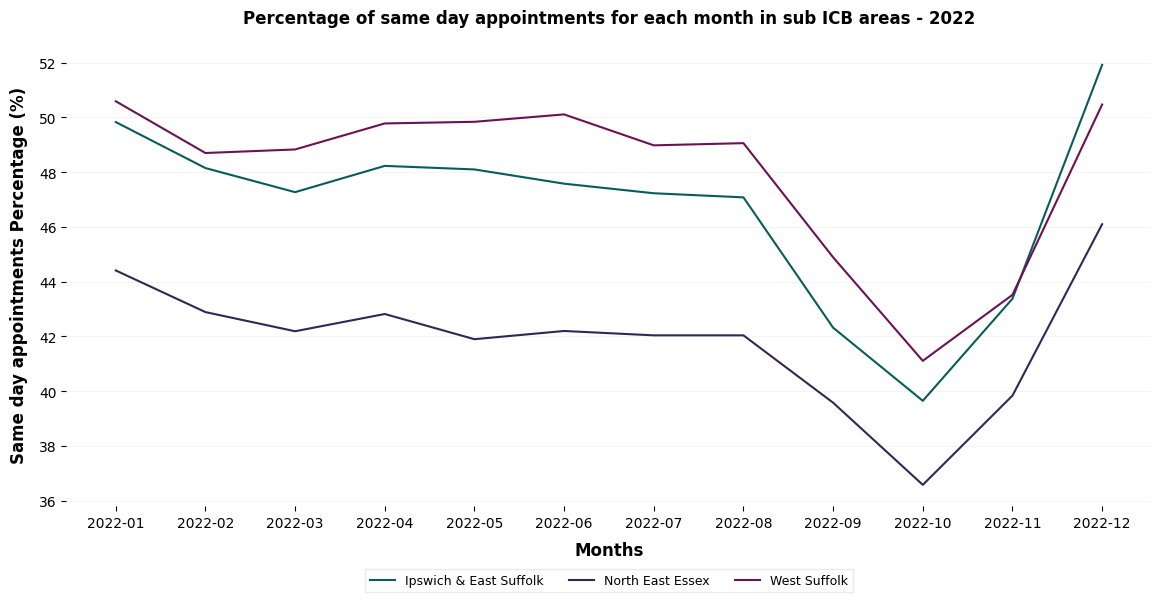

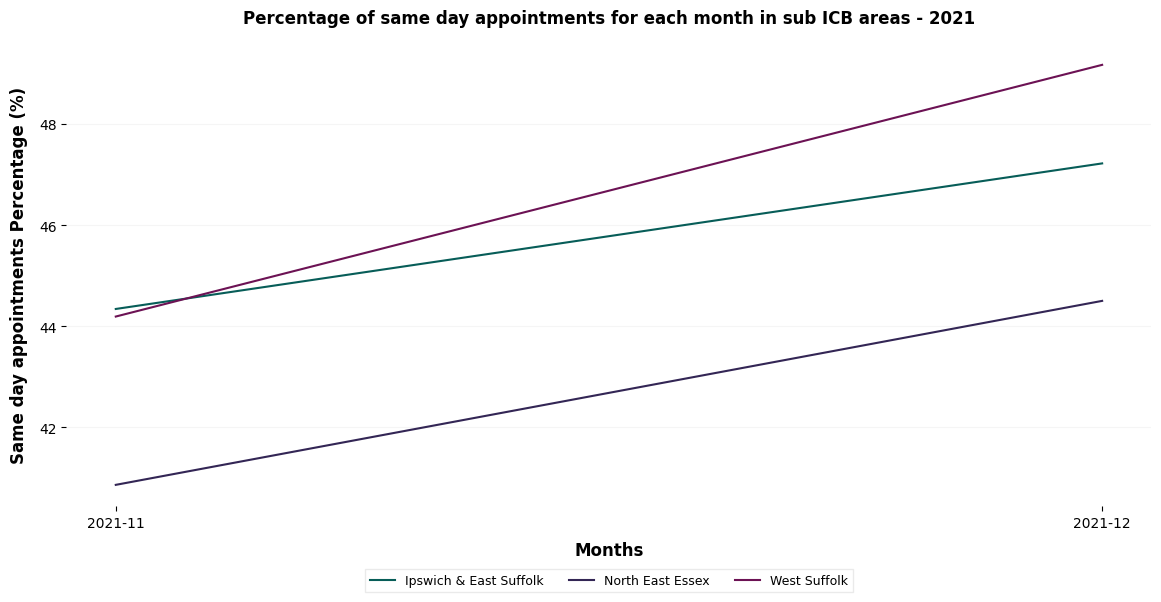

In [6]:
def make_lineplot(data: pd.DataFrame, xcol, ycol, hue, xlabel, ylabel, title):
    data = data.sort_values(xcol)
    plt.subplots(figsize=(14,6))
    sns.lineplot(data=data, x=data[xcol].astype(str), y=ycol, hue=hue)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(bbox_to_anchor=(0.5,-0.2), ncol=3)


# Plotting % on the day appointments by ICB for year - 2023
make_lineplot(pct_appointments_df_2023, 'MONTH_YEAR', 'PCT_SAME_DAY_APPT', 'SUB_ICB_CODE', 'Months', 'Same day appointments Percentage (%)', 'Percentage of same day appointments for each month in sub ICB areas - 2023')


# Plotting % on the day appointments by ICB for year - 2022
make_lineplot(pct_appointments_df_2022, 'MONTH_YEAR', 'PCT_SAME_DAY_APPT', 'SUB_ICB_CODE', 'Months', 'Same day appointments Percentage (%)', 'Percentage of same day appointments for each month in sub ICB areas - 2022')


# Plotting % on the day appointments by ICB for year - 2021
make_lineplot(pct_appointments_df_2021, 'MONTH_YEAR', 'PCT_SAME_DAY_APPT', 'SUB_ICB_CODE', 'Months', 'Same day appointments Percentage (%)', 'Percentage of same day appointments for each month in sub ICB areas - 2021')

## 5. Bar plot for the last 12 months of appointment data. (x values: ICB, y values:% on the day appointments)

In [7]:
def make_barplot(data: pd.DataFrame, xcol, ycol, hue, xlabel, ylabel, title):
    data = data.sort_values(xcol)
    plt.subplots(figsize=(14,6))
    sns.barplot(data=data, x=data[xcol].astype(str), y=ycol, hue=hue)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(bbox_to_anchor=(0.5,-0.2), ncol=3)

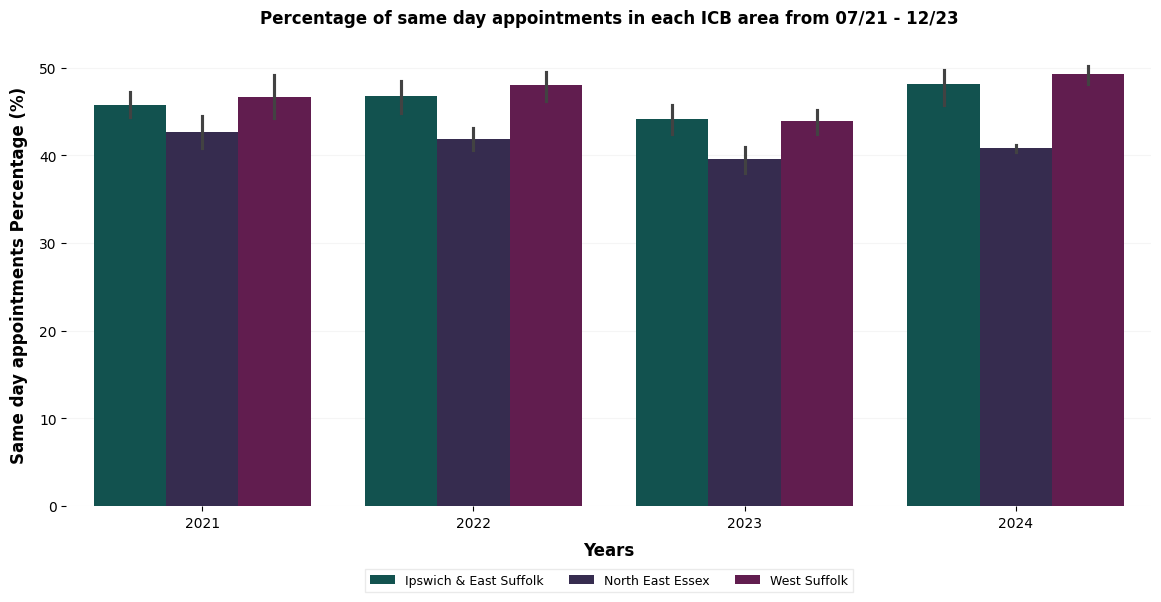

In [8]:
# Plotting % on the day appointments by ICB for all years on a bargraph
pct_appointments_df = pct_appointments_df.sort_values('MONTH_YEAR')
make_barplot(pct_appointments_df, "YEAR", 'PCT_SAME_DAY_APPT', 'SUB_ICB_CODE', 'Years', 'Same day appointments Percentage (%)', 'Percentage of same day appointments in each ICB area from 07/21 - 12/23')

In [9]:
# Creating a dataframe to incorporate staff type
staff_df = (snee_appointments_df
            .groupby(['SUB_ICB_LOCATION_CODE','sameday','HCP_TYPE','APPOINTMENT_MONTH'])[['COUNT_OF_APPOINTMENTS']].sum()
            .reset_index()
            .pivot(index=['SUB_ICB_LOCATION_CODE','APPOINTMENT_MONTH','HCP_TYPE'],values='COUNT_OF_APPOINTMENTS',columns='sameday')
            .reset_index().rename(columns={True:'True',False:'False'})
            )


staff_df['pct'] = (staff_df['True']/(staff_df['False']+staff_df['True'])*100).round(2)
staff_df.head()

sameday,SUB_ICB_LOCATION_CODE,APPOINTMENT_MONTH,HCP_TYPE,False,True,pct
0,Ipswich & East Suffolk,APR2022,GP,18863,42708,69.36
1,Ipswich & East Suffolk,APR2022,Other Practice staff,61380,31868,34.18
2,Ipswich & East Suffolk,APR2022,Unknown,5422,5226,49.08
3,Ipswich & East Suffolk,APR2023,GP,19809,38781,66.19
4,Ipswich & East Suffolk,APR2023,Other Practice staff,70496,32750,31.72


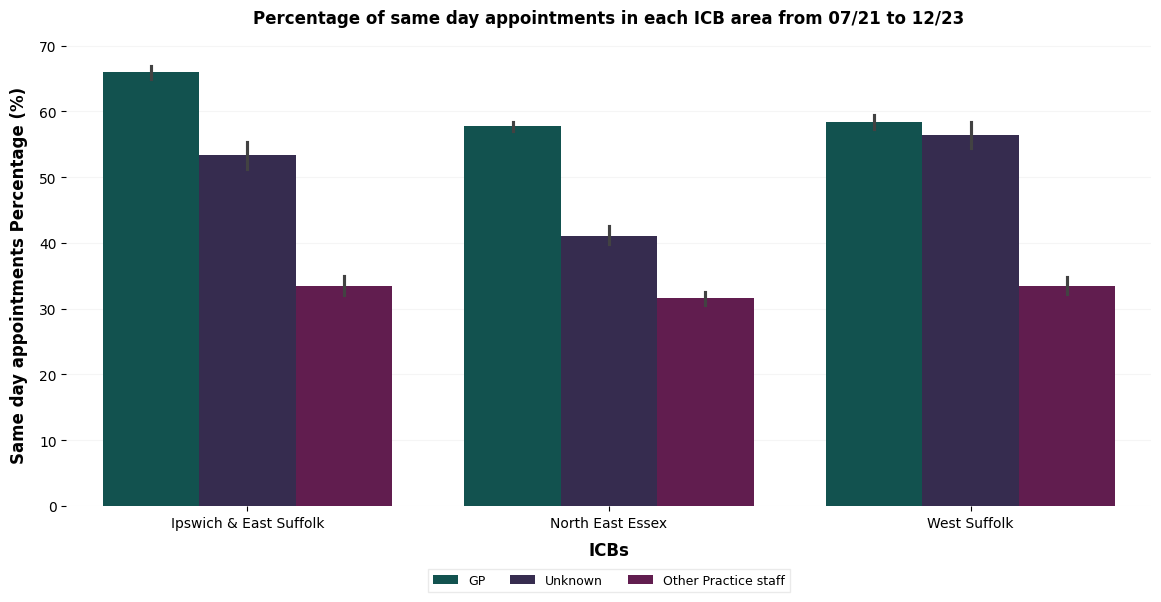

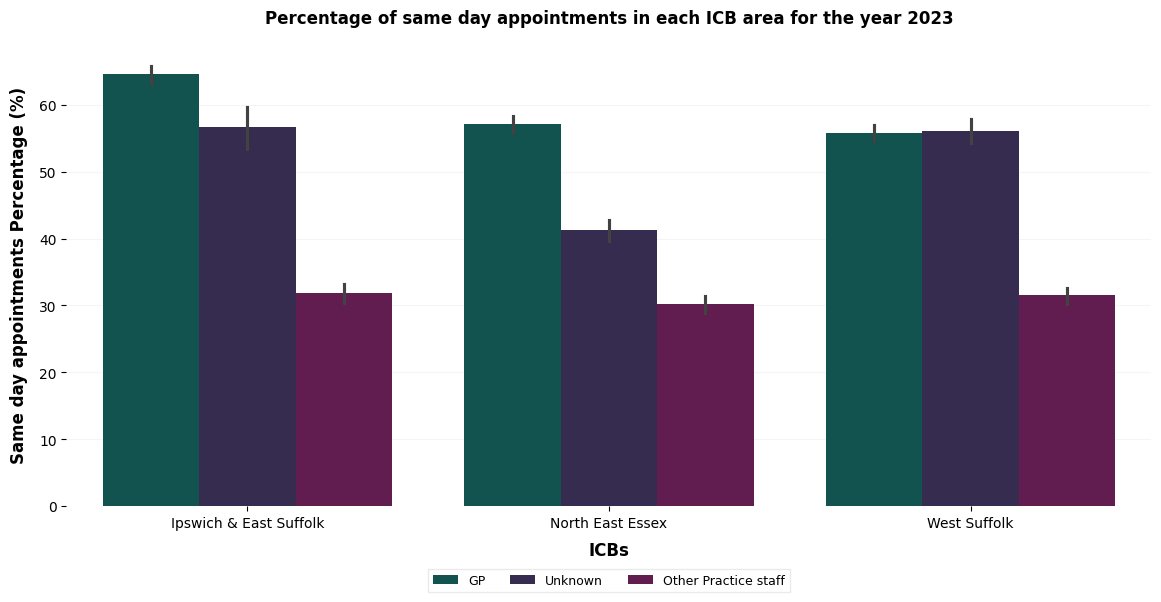

In [10]:
# Plotting % on the day appointments by HCP_TYPE and ICB from 07/21 to 12/23
make_barplot(staff_df, "SUB_ICB_LOCATION_CODE", 'pct', 'HCP_TYPE', 'ICBs', 'Same day appointments Percentage (%)', 'Percentage of same day appointments in each ICB area from 07/21 to 12/23')


# Plotting % on the day appointments by HCP_TYPE and ICB for 2023
staff_df_2023 = staff_df[staff_df['APPOINTMENT_MONTH'].str.endswith('2023')]
make_barplot(staff_df_2023, "SUB_ICB_LOCATION_CODE", 'pct', 'HCP_TYPE', 'ICBs', 'Same day appointments Percentage (%)', 'Percentage of same day appointments in each ICB area for the year 2023')

## 6. Output in YAML file

In [11]:
# Converting to Dictionary
pct_appointments_df_for_dict = pct_appointments_df_2023.drop(columns=['YEAR','ALL_APPOINTMENTS','SAME_DAY_APPOINTMENTS','MONTH_YEAR']).groupby(['SUB_ICB_CODE']).mean().round(2)
pct_appointments_df_for_dict

,PCT_SAME_DAY_APPT
SUB_ICB_CODE,
Ipswich & East Suffolk,44.16
North East Essex,39.53
West Suffolk,43.87


In [12]:
# Replacing the sub-icb location names with codes
index_with_codes = ["06L", "06T", "07K"]
pct_appointments_df_for_dict.index = index_with_codes

# Converting dataframe to dictionary for YAML output
pct_appointments_dict = pct_appointments_df_for_dict.squeeze().to_dict()

{'06L': 44.16, '06T': 39.53, '07K': 43.87}

In [13]:
# Saving Output to yaml
with open(constants.SAME_DAY_APPOINTMENT_OUTPUT_FILENAME, 'w') as yaml_file:
    yaml.dump(pct_appointments_dict, yaml_file)